#Дипломная работа(практика)

##Загрузка датасета с сайта OpenML

Скачиваем модуль для работы с объектами с сайта OpenML, модуль pyspark и модуль pandas для дальнейшей работы с датасетом

Используем `>> None` для того, чтобы не выводить инофрмацию об установке

In [1]:
!pip install openml >> None
!pip install pyspark >> None
!pip install pandas >> None

In [2]:
import openml
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark import SparkContext, SparkConf

# 45955 - id нужного датасета на сайте OpenML
id = 45955

# Загружаем датасет с сайта в объект dataset
dataset = openml.datasets.get_dataset(id)

print(type(dataset))

# Переносим датасет из объекта OpenMLDataset
df, _, _, _ = dataset.get_data(dataset_format="dataframe")
df = df.drop(columns='used_chip')

<class 'openml.datasets.dataset.OpenMLDataset'>


In [3]:
conf = SparkConf().setAppName("FraudDetection").setMaster("local[*]")
sc = SparkContext(conf=conf)

spark = SparkSession.builder.getOrCreate()

In [4]:
spark_df = spark.createDataFrame(df)

###Описание атрибутов:

- distance_from_home: это числовой признак, представляющий географическое расстояние в километрах между местом транзакции и домашним адресом владельца карты.
- distance_from_last_transaction: этот числовой атрибут измеряет расстояние в километрах от места последней транзакции до текущего местоположения транзакции.
- Ratio_to_median_purchase_price: числовое соотношение, которое сравнивает цену транзакции со средней ценой покупки в истории транзакций пользователя.
- повтор_ритейлер: двоичный атрибут, где «1» означает, что транзакция была проведена у розничного продавца, ранее использовавшегося держателем карты, а «0» указывает на нового розничного продавца.
- Used_pin_number: еще одна двоичная функция, где «1» означает использование PIN-кода для транзакции, а «0» означает, что PIN-код не использовался.
- online_order: этот атрибут определяет, была ли покупка совершена онлайн («1») или оффлайн («0»).
- мошенничество: двоичная целевая переменная, указывающая, была ли транзакция мошеннической («1») или нет («0»).

In [5]:
# Выведем первые 5 строк, чтобы посмотреть структуру датасета
df.head()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_pin_number,online_order,fraud
0,57.877857,0.311140,1.945940,1,0,0,0
1,10.829943,0.175592,1.294219,1,0,0,0
2,5.091079,0.805153,0.427715,1,0,1,0
3,2.247564,5.600044,0.362663,1,0,1,0
4,44.190936,0.566486,2.222767,1,0,1,0


In [6]:
# Со спарком сделаем то же самое
spark_df.show(5)

+------------------+------------------------------+------------------------------+---------------+---------------+------------+-----+
|distance_from_home|distance_from_last_transaction|ratio_to_median_purchase_price|repeat_retailer|used_pin_number|online_order|fraud|
+------------------+------------------------------+------------------------------+---------------+---------------+------------+-----+
|     57.8778565839|                   0.311140008|            1.9459399776000001|              1|              0|           0|    0|
|     10.8299426993|                  0.1755915023|            1.2942188105999999|              1|              0|           0|    0|
|      5.0910794906|                  0.8051525946|                  0.4277145612|              1|              0|           1|    0|
|      2.2475643283|                   5.600043547|                  0.3626625781|              1|              0|           1|    0|
|     44.1909360026|                  0.5664862681|           

## Обработка данных и EDA

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Выведем инофрмацию о типах значений в полях, пропущенных значениях
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 7 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   distance_from_home              1000000 non-null  float64
 1   distance_from_last_transaction  1000000 non-null  float64
 2   ratio_to_median_purchase_price  1000000 non-null  float64
 3   repeat_retailer                 1000000 non-null  uint8  
 4   used_pin_number                 1000000 non-null  uint8  
 5   online_order                    1000000 non-null  uint8  
 6   fraud                           1000000 non-null  uint8  
dtypes: float64(3), uint8(4)
memory usage: 26.7 MB


**Пропущенных значений нет**

In [9]:
# Выведем статистику по каждому столбцу(минимальное, максимальное, среднее значения, перцентили)
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_pin_number,online_order,fraud
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.100608,0.650552,0.087403
std,65.390784,25.843093,2.799589,0.323157,0.300809,0.476796,0.282425
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,1.000000,0.000000
75%,25.743985,3.355748,2.096370,1.000000,0.000000,1.000000,0.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000


**Из полученных данных видно, что ни один столбец не обладает аномалиями(дистанция не отрицательна, отношения положительно, последние колонки принимают лишь значения 0 и 1)**

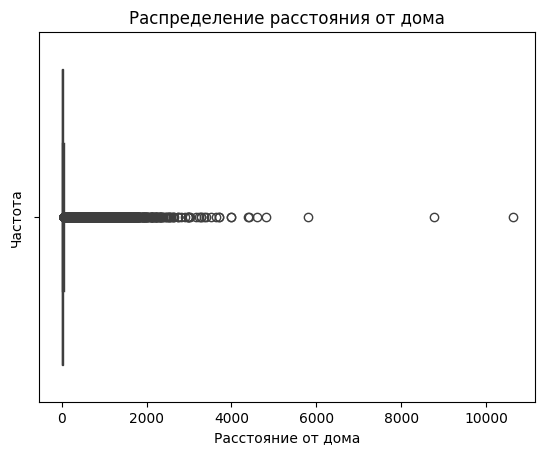

In [10]:
# Выведем boxplot распредления расстояния от дома
sns.boxplot(x=df['distance_from_home'])
plt.title('Распределение расстояния от дома')
plt.xlabel('Расстояние от дома')
plt.ylabel('Частота')
plt.show()

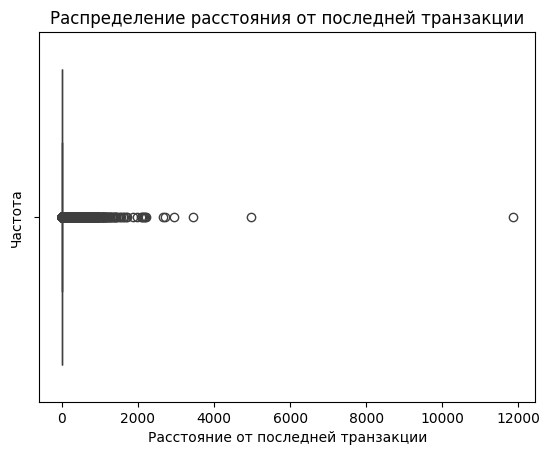

In [11]:
# Выведем boxplot распредления расстояния от последней транзакции
sns.boxplot(x=df['distance_from_last_transaction'])
plt.title('Распределение расстояния от последней транзакции')
plt.xlabel('Расстояние от последней транзакции')
plt.ylabel('Частота')
plt.show()

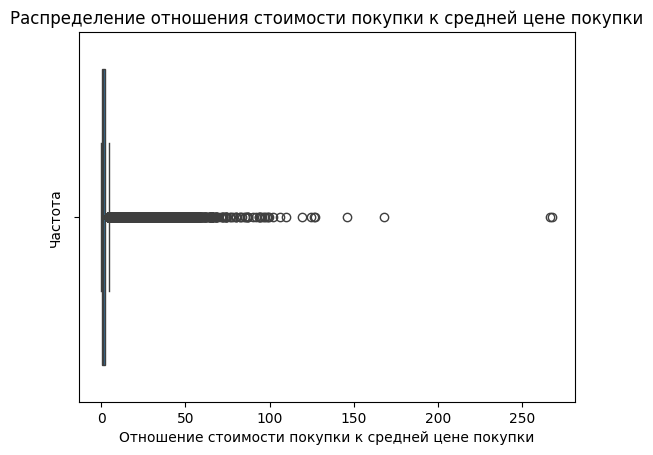

In [12]:
# Выведем boxplot распредления расстояния от последней транзакции
sns.boxplot(x=df['ratio_to_median_purchase_price'])
plt.title('Распределение отношения стоимости покупки к средней цене покупки')
plt.xlabel('Отношение стоимости покупки к средней цене покупки')
plt.ylabel('Частота')
plt.show()

**Из полученных данных видно, что распределение имеет длинный правый хвост**

Мы можем попытаться "обрезать" этот хвост по правилу трёх сигм или по перцентилям, однако мы можем потерять важные для дальнейшего обучения модели данные.

In [13]:
import numpy as np
# Вместо "обрезания" хвоста воспользуемся преобразованием данных, используя натуральный логорифм
# Такое преобразование поможет сохранить все данные и избавит от больших чисел
df_ln = df[['distance_from_home','distance_from_last_transaction', 'ratio_to_median_purchase_price']].map(lambda x: np.log(x))
df_ln = pd.concat([df_ln,df[['repeat_retailer','used_pin_number','online_order','fraud']]],axis=1)

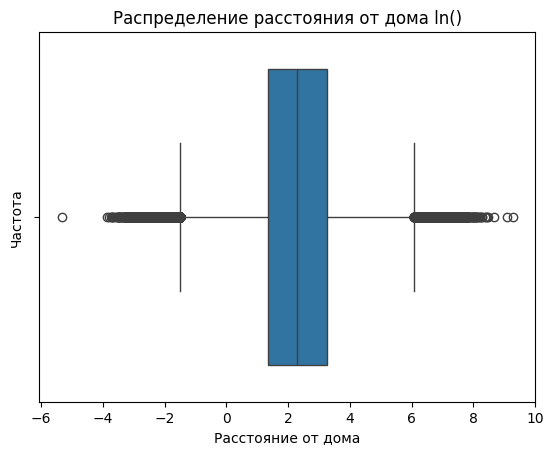

In [14]:
# Выведем boxplot распредления расстояния от дома после log-преобразования
sns.boxplot(x=df_ln['distance_from_home'])
plt.title('Распределение расстояния от дома ln()')
plt.xlabel('Расстояние от дома')
plt.ylabel('Частота')
plt.show()

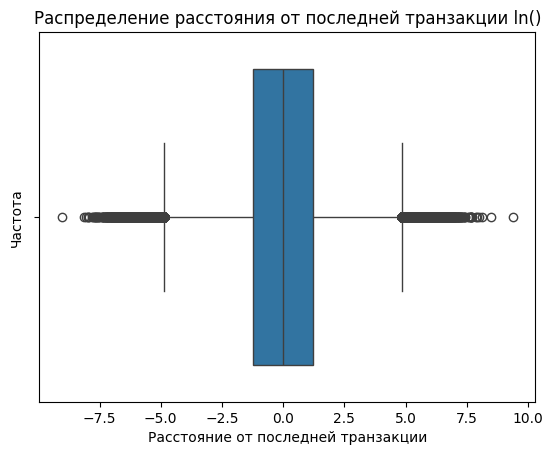

In [15]:
# Выведем boxplot распредления расстояния от последней транзакции после log-преобразования
sns.boxplot(x=df_ln['distance_from_last_transaction'])
plt.title('Распределение расстояния от последней транзакции ln()')
plt.xlabel('Расстояние от последней транзакции')
plt.ylabel('Частота')
plt.show()

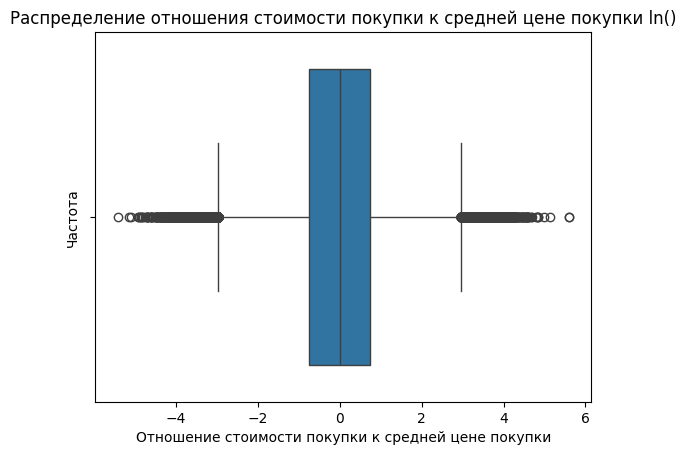

In [16]:
# Выведем boxplot распредления расстояния от последней транзакции
sns.boxplot(x=df_ln['ratio_to_median_purchase_price'])
plt.title('Распределение отношения стоимости покупки к средней цене покупки ln()')
plt.xlabel('Отношение стоимости покупки к средней цене покупки')
plt.ylabel('Частота')
plt.show()

**Из полученных данных стало видно, что теперь все данные лучше локализованы, и распределение не имеет такие большие выбросы**

In [17]:
import pyspark.sql.functions as F
fraud_count_depends_on_online = spark_df.select('online_order','fraud').groupBy('online_order','fraud').agg(F.count('fraud').alias('count'))
fraud_count_depends_on_online.show()

+------------+-----+------+
|online_order|fraud| count|
+------------+-----+------+
|           1|    0|567841|
|           1|    1| 82711|
|           0|    1|  4692|
|           0|    0|344756|
+------------+-----+------+



In [18]:
fraud_count_depends_on_online.filter(F.col('fraud') == 1).show()

+------------+-----+-----+
|online_order|fraud|count|
+------------+-----+-----+
|           1|    1|82711|
|           0|    1| 4692|
+------------+-----+-----+



In [19]:
fraud_count = spark_df.select('repeat_retailer','used_pin_number','online_order','fraud').groupBy('repeat_retailer','used_pin_number','online_order','fraud').agg(F.count('fraud').alias('count')).orderBy('fraud')
fraud_count.show()

+---------------+---------------+------------+-----+------+
|repeat_retailer|used_pin_number|online_order|fraud| count|
+---------------+---------------+------------+-----+------+
|              0|              0|           1|    0| 61308|
|              1|              1|           0|    0| 31083|
|              0|              1|           0|    0|  4115|
|              0|              1|           1|    0|  7830|
|              1|              1|           1|    0| 57307|
|              1|              0|           1|    0|441396|
|              1|              0|           0|    0|274825|
|              0|              0|           0|    0| 34733|
|              1|              0|           1|    1| 74442|
|              1|              1|           1|    1|   258|
|              0|              0|           1|    1|  7997|
|              0|              1|           1|    1|    14|
|              0|              0|           0|    1|  2467|
|              1|              0|       

Исходя из результатов, можно сказать, что

1. Почти все операции, в которых использовался пин-код, являются не мошенническими.
2. Большая часть мошеннических операций приходится на онлайн транзакции
3. Больше всего мошеннических транзакций происходило в том случае, когда покупка совершалась онлайн у "старого" продавца, не используя пин-код
4. И был всего один случай, когда покупка совершённая оффлайн у "старого" продавца, используя пин-код, считалась мошеннической. Быть может это была кража карты вместе с пин-кодом. Либо мошенник до этого знал пин-код к карте и ему оставалось лишь своровать карту.

In [20]:
def set_category(x):
    if x < 2:
      return "normal"
    elif x < 4:
      return "medium"
    else:
      return "high"

In [21]:
from pyspark.sql.types import StringType

set_category_udf = F.udf(set_category, StringType())

df_with_cateroties_of_ratio = spark_df.withColumn('Category',set_category_udf(F.col('ratio_to_median_purchase_price')))

In [22]:
df_with_cateroties_of_ratio.select('Category','fraud').groupBy('Category','fraud').agg(F.count('fraud').alias('count')).orderBy('fraud').show()

+--------+-----+------+
|Category|fraud| count|
+--------+-----+------+
|  medium|    0|156547|
|  normal|    0|717841|
|    high|    0| 38209|
|  medium|    1|  4036|
|  normal|    1| 18416|
|    high|    1| 64951|
+--------+-----+------+



Больше всего мошеннических транзакций было произведено, когда отношение стоимости покупки к средней цене составляло более 4, меньше всего от 2 до 4. Это может быть связано с тем, что мошенники в большинстве случаев тратят чужие деньги на нечто крупное(по стоимости).

In [23]:
def set_distance_category(x):
    if x < 5:
      return "low"
    elif x < 40:
      return "normal"
    elif x < 100:
      return "medium"
    else:
      return "high"

In [24]:
set_distance_category_udf = F.udf(set_distance_category, StringType())
df_with_distance_from_home_category = spark_df.withColumn('distance_from_home_category',set_distance_category_udf(F.col('distance_from_home')))
df_with_distance_from_home_category = df_with_distance_from_home_category.withColumn('distance_from_last_transaction_category',set_distance_category_udf(F.col('distance_from_last_transaction')))

In [25]:
df_with_distance_from_home_category.select('distance_from_home_category','distance_from_last_transaction_category','fraud').groupBy('distance_from_home_category','distance_from_last_transaction_category','fraud').agg(F.count('fraud').alias('count')).orderBy('fraud').show(50)

+---------------------------+---------------------------------------+-----+------+
|distance_from_home_category|distance_from_last_transaction_category|fraud| count|
+---------------------------+---------------------------------------+-----+------+
|                        low|                                 medium|    0|  2945|
|                     normal|                                 normal|    0| 81800|
|                     normal|                                 medium|    0|  5431|
|                        low|                                    low|    0|236313|
|                     normal|                                   high|    0|  1580|
|                        low|                                   high|    0|   774|
|                        low|                                 normal|    0| 47896|
|                     medium|                                 medium|    0|  1202|
|                       high|                                 medium|    0|   205|
|   

Получилось, что больше всего мошеннических операций приходится на очень маленькие расстояния от последней покупки, но на разные расстояния от дома.

Дополним датасет данными об онлайн и оффлайн транзакциях



In [26]:
df_with_distance_from_home_category\
                                    .select('distance_from_home_category','distance_from_last_transaction_category','online_order','fraud')\
                                    .groupBy('distance_from_home_category','distance_from_last_transaction_category','online_order','fraud')\
                                    .agg(F.count('fraud').alias('count'))\
                                    .orderBy('fraud')\
                                    .filter(F.col('fraud')==1)\
                                    .show(50)

+---------------------------+---------------------------------------+------------+-----+-----+
|distance_from_home_category|distance_from_last_transaction_category|online_order|fraud|count|
+---------------------------+---------------------------------------+------------+-----+-----+
|                       high|                                 medium|           1|    1|  393|
|                     normal|                                   high|           1|    1| 1121|
|                     medium|                                   high|           1|    1|  229|
|                       high|                                 normal|           1|    1| 3278|
|                     medium|                                   high|           0|    1|   20|
|                        low|                                 medium|           1|    1| 1524|
|                        low|                                 normal|           1|    1| 3049|
|                        low|                     

Теперь имеем более подходящую для анализа картину.

Рассмотрим три самых больших по количеству моженнических транзакций. Как видно из таблицы это значения `25887` `16549` и `15366`

Рассмотрим остальные характеристики этих значений. Все эти операции были сделаны онлайн. А теперь рассмотрим их по отдельности:

1.  normal-low - то есть очень маленькое расстояние от последней транзакции и чуть большее от дома. Быть может мошенник находился в чертах одного города и совершил транзакцию где-то рядом с последней покупкой. Например: Человек О(обладатель карты) был в общественном месте, к примеру, в торговом центре вдали от дома. Человек М(Мошенник) увидел, как человек О расплачивался картой за еду. М успел сфотографировать данные карты и уехал из торгового центра на расстояние меньше 5 километров. М Совершил перевод с карты или оплатил покупку с этого места.

2.  high-low - то есть очень маленькое расстояние от последней транзакции и большое от дома. Быть может М произвёл две транзакции. Одну транзакцию произвели "для вида". Показать, будто О находится в другом городе, далеко от своего дома. А вторую транзакцию М произвёл уже для того, чтобы украсть деньги или совершить большую покупку.

3.  low-low - то есть очень маленькое расстояние от последней транзакции и от дома. В пределах маленького города очень даже реальная ситуация. Быть может даже М использовал прокси сервер таковой, что его местоположение почти совпало с адресом О. Даже если взять город радиусом 5 километров, а в центре размещён сервер, то в полне можно подтвердить данные значения по количеству мошеннических транзакций

## Создание, обучение и тестирование модели, используя PyTorch

### Обработка данных

In [27]:
value = df_ln['fraud'].value_counts()[1]/df_ln['fraud'].value_counts()[0]*100
print(f'{round(value,1)}%')

9.6%


Сами по себе данные не сбалансированы. Доля мошеннических операций составляет всего 9.6%

Этого может не хватить, чтобы обучить модель правильно различать данные. Поэтому можно применить операцию `oversampling` над мошенническими транзакциями.

Можно было пойти простым путём и просто дублировать транзакции, однако модель могла бы легко начать переобучаться, так как каждый раз может встречать одни и те же данные, а при встрече новых может не понять,что делать.

Поэтому воспользуемся SMOTE(Synthetic Minority Oversampling Technique). То есть воспользуемся функцией, которая синтезирует новые мошеннические транзакции, опираясь на уже существующие. То есть выполнит аугментацию данных. Данные будут похожи на существующие, но не будут являться дубликатами.

In [28]:
from imblearn.over_sampling import SMOTE

data = df_ln.copy()
# Разделяем на признаки и целевую переменную
X = data.drop(columns=['fraud'])
y = data['fraud']

# Применяем SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Создаём новый DataFrame
data_resampled = pd.concat([pd.DataFrame(X_resampled), pd.DataFrame(y_resampled, columns=['fraud'])], axis=1)

### Создание модели

После того, как данные для обучения были подготовлены, можно начинать создание модели.

In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

# Загрузка данных
data = data_resampled.copy()

# Разделение на фичи и целевую переменную
X = data.drop(columns=["fraud"])
y = data["fraud"]


In [30]:
# разделяем датасет на тренировочный и тестовый (метки отдельно)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify=y, random_state=42)

In [31]:
# Стандартизируем данные(приводим их к нормальному виду)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
# Создаём класс для работы с датасетами PyTorch
class TransactionDataset(Dataset):
    def __init__(self, X, y):
        # Переводим наши данные в тензоры, так как в PyTorch почти все операции происходят именно с ними
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    # Создаём метод для нахождения количества данных(количество строк)
    def __len__(self):
        return len(self.y)

    # Создаём метод для получения i-ой строки
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Создаём объекты нашего класса, для последующей загрузки в DataLoader
train_dataset = TransactionDataset(X_train, y_train)
test_dataset = TransactionDataset(X_test, y_test)

# Создаём лоадеры для тренировочного и тестового датасетов, чтобы данные могли подаваться порциями(батчами)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # Разрешаем перемешивание данных
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False) # Запрещаем перемешивание данных

In [33]:
# Создаём нашу модель
class FraudDetectionNN(nn.Module):
    # Описываем структуру нашей модели
    def __init__(self):
        super(FraudDetectionNN, self).__init__()
        # Модель будет состоять из 5 полносвязных слоёв. На каждом слояе, кроме выходного определим функцию ReLU, чтобы избавиться от отрицательных значений нейронов.
        # А на последнем используем sigmoid, чтобы выдать вероятность предсказания.
        self.layers = nn.Sequential(
            nn.Linear(X_train.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Объявляем модель и переносим её на графический процессор, если есть такая возможность
model = FraudDetectionNN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)

cuda


In [34]:
# Конвертируем данные из объекта y_train в тензор PyTorch с целочисленным типом данных
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)

In [35]:
# Указываем функцию потерь (Binary-CrossEntropy loss) для бинарной классификации
criterion = nn.BCELoss()
# Указываем оптимизатор Adam, который адаптирует шаг обучения для каждого параметра модели на основе истории градиентов и их моментов (среднего и дисперсии)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

### Обучение модели

In [36]:
# Задаём количество эпох
epochs = 20
# Переключаем модель в режим обучения
model.train()

for epoch in range(epochs):
    # На каждой эпохе обнуляем ошибку
    epoch_loss = 0
    for X_batch, y_batch in train_loader:
        # Переносим батчи на устройство(cuda или cpu)
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        # Обнуляем градиенты, чтобы избежать их накопления
        optimizer.zero_grad()
        # Пропускаем батч через модель и убираем измерения с размерностью 1 (если такие имеются) во выходных данных
        outputs = model(X_batch).squeeze()
        # Считаем ошибку
        loss = criterion(outputs, y_batch)
        # Обратное распространение ошибок(вычисление градиентов)
        loss.backward()
        # Применение к параметрам модели вычисленных градиентов
        optimizer.step()
        # Суммирование ошибки
        epoch_loss += loss.item()
    # Выводим номер эпохи и значение функции потерь эпохи
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/len(train_loader)}")


Epoch 1/20, Loss: 0.20270767780583315
Epoch 2/20, Loss: 0.04585201223685644
Epoch 3/20, Loss: 0.039054277466485494
Epoch 4/20, Loss: 0.03692179983232634
Epoch 5/20, Loss: 0.035844742815947205
Epoch 6/20, Loss: 0.035051856554767544
Epoch 7/20, Loss: 0.034480242617706554
Epoch 8/20, Loss: 0.03408105064783456
Epoch 9/20, Loss: 0.03377669528413112
Epoch 10/20, Loss: 0.03337092990448602
Epoch 11/20, Loss: 0.03317251743891664
Epoch 12/20, Loss: 0.033114603463497726
Epoch 13/20, Loss: 0.032839007942681166
Epoch 14/20, Loss: 0.03279801994160111
Epoch 15/20, Loss: 0.03261319980853614
Epoch 16/20, Loss: 0.032561672320907266
Epoch 17/20, Loss: 0.03246155942105556
Epoch 18/20, Loss: 0.03241183734113303
Epoch 19/20, Loss: 0.03232367258187206
Epoch 20/20, Loss: 0.032236243298839534


### Тестирование модели

In [37]:
# Переключаем модель в режим предсказания(тестирования)
model.eval()
y_pred = []
y_true = []
# Отключаем градиенты, чтобы сэкономить память
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        outputs = model(X_batch).squeeze()
        # Конвертируем предсказания в 1 или 0
        y_pred.extend((outputs > 0.5).int().tolist())
        # Конвертируем метки в 1 или 0
        y_true.extend(y_batch.int().tolist())

from sklearn.metrics import f1_score
# Выводим статистику о предсказании модели
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    365039
           1       0.98      1.00      0.99    365039

    accuracy                           0.99    730078
   macro avg       0.99      0.99      0.99    730078
weighted avg       0.99      0.99      0.99    730078



Модель очень хорошо себя показала на предсказании тестовых данных. Даже почти идеально предсказала. Точность составила 0.99

In [38]:
# Отключаем градиенты, чтобы сэкономить память
with torch.no_grad():
    y_pred_probs = model(torch.tensor(X_test, dtype=torch.float32).to(device))
    y_pred = (y_pred_probs >= 0.5).int()


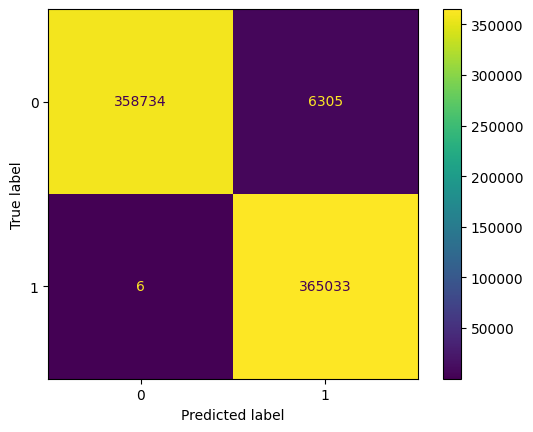

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Создаём матрицу ошибок, сравнивая истинные метки y_test с предсказаниями модели y_pred
cm = confusion_matrix(y_test, y_pred.cpu().numpy())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
# Выводим матрицу ошибок
disp.plot();

Из матрицы видно, что модель очень хорошо стправляется с классификацией, но так же есть и ошибки, когда неверно предсказывает метку мошеннической операции.

### Тестируем модель на придуманных ситуациях

In [40]:
# Создаём функцию для предсказания типа транзакции(мошенническая-1 или нет-0)
def predict(new_data):
    # Выполняем логорифмирование данных, чтобы улучшить их локализацию в пространстве
    for row_index in range(len(new_data)):
        new_data[row_index][:2] = list(map(lambda x: np.log(x), new_data[row_index][:2]))
    # Конвертируем данные в тензор PyTorch
    new_test = scaler.transform(new_data)
    new_data_tensor = torch.tensor(new_test, dtype=torch.float32).to(device)
    # Выполняем предсказание
    with torch.no_grad():  # Выключаем градиенты
        predictions = model(new_data_tensor).squeeze()  # Получаем вероятности
        predicted_labels = (predictions >= 0.5).int()  # Преобразуем вероятности в классы (0 или 1)

    # Выводим результаты
    for i, (data, label, prob) in enumerate(zip(new_data, predicted_labels, predictions)):
        print(f"Пример {i + 1}: Данные: {data}, Вероятность мошенничества: {prob:.2f}, Метка: {label.item()}")

Смоделируем несколько ситуаций, чтобы проверить, как работает нейросеть. Иными словами, придумаем данные под какой-либо небольшой сюжет. Поймёт ли нейросеть класс транзакции

- Случай 1:

Пользователь карты уехал в другой город, в котором он уже когда-то бывал. В этом городе он поехал в магазин одежды, где уже покупал что-то не в первый раз. Решил купить там телевизор. При оплате он ввёл пин-код на терминале.

Входные данные:

Расстояние от дома: 50.3

Расстояние от последней покупки: 51.6

Отношение цены покупки к средней цене покупок: 2.3

“Старый” продавец: да

Использование пин-кода: да

Онлайн покупка: нет


- Случай 2:

Пользователь карты, будучи на работе, решил заказать своей девушке доставку цветов. Не раз покупал у этого продавца цветы. При покупке в этом магазине у него всегда запрашивают пин-код карты.

Входные данные:

Расстояние от дома: 3.45

Расстояние от последней покупки: 6.0

Отношение цены покупки к средней цене покупок: 1.5

“Старый” продавец: да

Использование пин-кода: да

Онлайн покупка: да


- Случай 3:

Пользователь карты находится в командировке в другом регионе. Во время поездки он решил заказать себе дорогой ноутбук в интернет-магазине, с которым он уже имел дело ранее. Однако через пару часов выясняется, что пользователь не совершал этой покупки. При проверке оказалось, что мошенники завладели данными карты и, зная привычки пользователя, сделали дорогостоящую покупку в знакомом магазине, чтобы не вызывать подозрений.

Входные данные:

Расстояние от дома: 500.10

Расстояние от последней покупки: 100.3

Отношение цены покупки к средней цене покупок: 3.5

“Старый” продавец: да

Использование пин-кода: да

Онлайн покупка: да

- Случай 4:

Пользователь карты обнаружил списание за покупку ювелирного украшения в интернет-магазине. Ранее он никогда не совершал покупок у этого продавца, и цена оказалась значительно выше его средних трат. Расследование показало, что мошенники использовали данные карты для покупки дорогого товара в новом магазине, не введя пин-код, и выбрали доставку на адрес, не связанный с владельцем карты.

Входные данные:

Расстояние от дома: 100.05

Расстояние от последней покупки: 120.0

Отношение цены покупки к средней цене покупок: 5.0

“Старый” продавец: нет

Использование пин-кода: нет

Онлайн покупка: да


In [41]:
# Формируем входные данные
new_data = [[50.3, 51.6, 2.3, 1, 1, 0],
            [3.45, 6.0, 1.5, 1, 1, 1],
            [500.10, 100.03, 3.5, 1 , 1 , 1],
            [100.05, 120.0, 5.0, 0 , 0 , 1]]
# Вызываем функцию для предсказания
predict(new_data)

Пример 1: Данные: [3.9180050771056933, 3.9435216724875173, 2.3, 1, 1, 0], Вероятность мошенничества: 0.00, Метка: 0
Пример 2: Данные: [1.2383742310432684, 1.791759469228055, 1.5, 1, 1, 1], Вероятность мошенничества: 0.00, Метка: 0
Пример 3: Данные: [6.214808078424858, 4.605470140997089, 3.5, 1, 1, 1], Вероятность мошенничества: 1.00, Метка: 1
Пример 4: Данные: [4.605670061029742, 4.787491742782046, 5.0, 0, 0, 1], Вероятность мошенничества: 1.00, Метка: 1


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
